In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
from matplotlib.ticker import FormatStrFormatter
import pickle
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [12]:
direc = 'G:/My Drive/Bas Games/Analysis/'
fig_direc = 'G:/My Drive/Bas Games/Figures/'

In [13]:
def ave_across_splits(p):
    return np.nanmean(np.reshape(p,[-1,5]),axis=1)

def get_mean(fname):
    try:
        x = np.loadtxt(fname)
        if len(x.shape)>1:
            return np.mean(x[:,np.nonzero(np.prod(x>0,axis=0))[0]])
        else:
            return np.mean(x)
    except OSError:
        print('File not found: ' + fname)
        return np.nan
    
def get_data(fname):
    try:
        x = np.loadtxt(fname)
        if len(x.shape)>1:
            return np.mean(x[:,np.nonzero(np.prod(x>0,axis=0))[0]],axis=1)
        else:
            print(fname,x.shape)
            return x
    except OSError:
        print('File not found: ' + fname)
        return np.full([200,],fill_value=np.nan)

In [14]:
models=['final','final_nonoise','final_nodelta','final_noprune','final_notree','final_noact','final_no3',
        'final_no2conn','final_nocenter','final_no4','final_no2unc',
        'final_optweights','final_mcts_myopic','final_drop_tile','final_fixed_iters',
        'final_fixed_depth','final_fixed_branch','final_weight_hvd','final_drop_hvd',
        'final_triangle','final_drop_type','final_opp']

model_names = ['Main','No value noise','No feature drop','No pruning','No tree','No active scaling',
               'No 3-in-a-row','No connected 2-in-a-row','No center','No 4-in-a-row',
               'No unconnected 2-in-a-row','Optimal weights','Monte Carlo Tree Search',
               'Tile dropping','Fixed iterations','Fixed depth','Fixed branching',
               'Orientation-dependent weights','Orientation-dependent dropping','Triangle',
               'Type-dependent dropping','Opponent scaling']

model_colors = ['black'] + ['#A30006']*10 + ['#025D8C']*6 + ['#519548']*5 + ['gray']

data_sets = ['hvh','gen','eye','learn1','learn2','learn3','tai1','tai2']


In [15]:
def parse_binstring(x):
    return np.array(list("{0:036b}".format(x))).astype(bool)

data_hvh = pd.read_csv(direc + 'data_hvh.txt',delim_whitespace=True,
                       names=['bp','wp','color','response','rt','group','subject'])
black_pieces = np.vstack(data_hvh['bp'].map(parse_binstring).values)
white_pieces = np.vstack(data_hvh['wp'].map(parse_binstring).values)
actual_moves = np.vstack(data_hvh['response'].map(parse_binstring).values)
occupied_squares = black_pieces + white_pieces

In [16]:
fourinarows = np.array([[ 0,  9, 18, 27], #hard-coding all ways in which four-in-a-row can appear
                       [ 1, 10, 19, 28],
                       [ 2, 11, 20, 29],
                       [ 3, 12, 21, 30],
                       [ 4, 13, 22, 31],
                       [ 5, 14, 23, 32],
                       [ 6, 15, 24, 33],
                       [ 7, 16, 25, 34],
                       [ 8, 17, 26, 35],
                       [ 0, 10, 20, 30],
                       [ 1, 11, 21, 31],
                       [ 2, 12, 22, 32],
                       [ 3, 13, 23, 33],
                       [ 4, 14, 24, 34],
                       [ 5, 15, 25, 35],
                       [ 3, 11, 19, 27],
                       [ 4, 12, 20, 28],
                       [ 5, 13, 21, 29],
                       [ 6, 14, 22, 30],
                       [ 7, 15, 23, 31],
                       [ 8, 16, 24, 32],
                       [ 0,  1,  2,  3],
                       [ 1,  2,  3,  4],
                       [ 2,  3,  4,  5],
                       [ 3,  4,  5,  6],
                       [ 4,  5,  6,  7],
                       [ 5,  6,  7,  8],
                       [ 9, 10, 11, 12],
                       [10, 11, 12, 13],
                       [11, 12, 13, 14],
                       [12, 13, 14, 15],
                       [13, 14, 15, 16],
                       [14, 15, 16, 17],
                       [18, 19, 20, 21],
                       [19, 20, 21, 22],
                       [20, 21, 22, 23],
                       [21, 22, 23, 24],
                       [22, 23, 24, 25],
                       [23, 24, 25, 26],
                       [27, 28, 29, 30],
                       [28, 29, 30, 31],
                       [29, 30, 31, 32],
                       [30, 31, 32, 33],
                       [31, 32, 33, 34],
                       [32, 33, 34, 35]],dtype=int)

In [8]:
n_3inarows_black = np.array([np.sum(np.logical_and(np.sum(bp[fourinarows],axis=1)==3,np.sum(wp[fourinarows],axis=1)==0)) 
                    for bp,wp in zip(black_pieces,white_pieces)])
n_3inarows_white = np.array([np.sum(np.logical_and(np.sum(wp[fourinarows],axis=1)==3,np.sum(bp[fourinarows],axis=1)==0)) 
                    for bp,wp in zip(black_pieces,white_pieces)])

In [9]:
np.nonzero(n_3inarows_black>1)

(array([  15,   38,   87,   94,  109,  130,  145,  158,  246,  247,  275,
         276,  290,  305,  393,  394,  404,  523,  547,  568,  577,  618,
         619,  639,  640,  654,  747,  749,  753,  817,  821,  822, 1019,
        1036, 1047, 1088, 1109, 1132, 1265, 1312, 1331, 1373, 1462, 1463,
        1469, 1470, 1489, 1504, 1505, 1582, 1586, 1596, 1597, 1611, 1649,
        1990, 2023, 2101, 2114, 2147, 2148, 2204, 2294, 2295, 2311, 2374,
        2385, 2435, 2465, 2563, 2633, 2671, 2689, 2910, 2917, 2932, 3101,
        3118, 3141, 3142, 3182, 3240, 3317, 3350, 3371, 3433, 3472, 3513,
        3567, 3603, 3776, 3867, 3917, 3942, 3957, 4076, 4077, 4113, 4115,
        4128, 4226, 4227, 4241, 4256, 4422, 4423, 4429, 4496, 4599, 4605,
        4612, 4694, 4701, 4718, 4810, 4837, 4849, 4870, 4970, 5193, 5195,
        5254, 5287, 5291, 5329, 5362, 5377, 5399, 5480], dtype=int64),)

In [10]:
move_stats_hvh = np.loadtxt(direc + 'Move statistics/move_stats_hvh.txt',dtype=int)
num_pieces_hvh = move_stats_hvh[:,3]
human_move = move_stats_hvh[:,4]
player = move_stats_hvh[:,0]
moves_left_hvh = np.hstack([np.arange(i,-1,-1) 
                            for i in num_pieces_hvh[np.hstack([np.nonzero(num_pieces_hvh==0)[0][1:]-1,[-1]])]])

In [11]:
model_moves_main = np.array([[np.loadtxt(direc + 'Model prediction/model_prediction/model_prediction_hvh_final_' + str(i) + '_' + str(g) + '.txt',dtype=int) 
                              for i in range(40)] for g in range(1,6)])

In [12]:
model_moves_notree = np.array([[np.loadtxt(direc + 'Model prediction/model_prediction/model_prediction_hvh_final_notree_' + str(i) + '_' + str(g) + '.txt',dtype=int) 
                              for i in range(40)] for g in range(1,6)])

In [13]:
model_moves_nodrop = np.array([[np.loadtxt(direc + 'Model prediction/model_prediction/model_prediction_hvh_final_nodelta_' + str(i) + '_' + str(g) + '.txt',dtype=int) 
                              for i in range(40)] for g in range(1,6)])

In [14]:
model_moves_optweights = np.array([[np.loadtxt(direc + 'Model prediction/model_prediction/model_prediction_hvh_final_optweights_' + str(i) + '_' + str(g) + '.txt',dtype=int) 
                              for i in range(40)] for g in range(1,6)])

In [15]:
model_moves_nonoise = np.array([[np.loadtxt(direc + 'Model prediction/model_prediction/model_prediction_hvh_final_nonoise_' + str(i) + '_' + str(g) + '.txt',dtype=int) 
                              for i in range(40)] for g in range(1,6)])

In [16]:
m_main = np.reshape(np.transpose(model_moves_main,(2,0,1,3)),[len(data_hvh),-1,10])
m_notree = np.reshape(np.transpose(model_moves_notree,(2,0,1,3)),[len(data_hvh),-1,10])
m_nodrop = np.reshape(np.transpose(model_moves_nodrop,(2,0,1,3)),[len(data_hvh),-1,10])
m_optweights = np.reshape(np.transpose(model_moves_optweights,(2,0,1,3)),[len(data_hvh),-1,10])
m_nonoise = np.reshape(np.transpose(model_moves_nonoise,(2,0,1,3)),[len(data_hvh),-1,10])
h_main = np.apply_along_axis(lambda arr: np.bincount(arr,minlength=36)/len(arr),1,m_main) 
h_notree = np.apply_along_axis(lambda arr: np.bincount(arr,minlength=36)/len(arr),1,m_notree)
h_nodrop = np.apply_along_axis(lambda arr: np.bincount(arr,minlength=36)/len(arr),1,m_nodrop)
h_optweights = np.apply_along_axis(lambda arr: np.bincount(arr,minlength=36)/len(arr),1,m_optweights)
h_nonoise =  np.apply_along_axis(lambda arr: np.bincount(arr,minlength=36)/len(arr),1,m_nonoise)

In [17]:
#model_moves_main = np.loadtxt(direc + 'Model Prediction/prediction_2.txt',dtype=int).T
#model_moves_notree = np.loadtxt(direc + 'Model Prediction/prediction_notree_2.txt',dtype=int).T

In [18]:
#accuracy_main = np.mean(m_main==human_move[:,None],axis=1)
#accuracy_notree = np.mean(m_notree==human_move[:,None],axis=1)

#notree_move = np.apply_along_axis(lambda arr: np.argmax(np.bincount(arr)),1,m_main)
#is_correct_notree = notree_move==human_move
#tree_move = np.apply_along_axis(lambda arr: np.argmax(np.bincount(arr)),1,m_notree)
#is_correct_tree = tree_move==human_move

In [19]:
from scipy.special import xlogy

def get_JS(X,Y):
    return np.sum((xlogy(X,X)+xlogy(Y,Y))/2-xlogy((X+Y)/2,(X+Y)/2),axis=1)

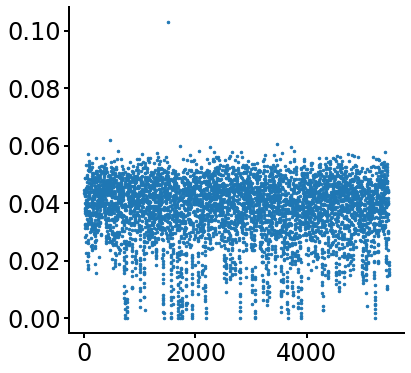

In [20]:
#plt.plot(get_JS(np.mean(h_main,axis=2),np.mean(h_nodrop,axis=2)),'.',markersize=5)
plt.plot(np.mean([get_JS(h_main[:,:,i],h_nodrop[:,:,i]) for i in range(10)],axis=0),'.',markersize=5)
#plt.plot(np.max(h_main-h_notree,axis=1),'.',markersize=5)
plt.show()

In [21]:
#Lfull = np.loadtxt(direc + 'Loglik/loglik_hvh_final_boards.txt')
#Llesion = np.loadtxt(direc + 'Loglik/loglik_hvh_final_nodelta_boards.txt')
#plt.plot(Lfull-Llesion,'.')
#plt.axhline(0,color='black',linestyle='dashed')
#plt.show()

In [22]:
x_nodrop = np.mean(h_main[np.arange(5482),human_move],axis=1)/np.mean(h_nodrop[np.arange(5482),human_move],axis=1)
x_notree = np.mean([get_JS(h_main[:,:,i],h_notree[:,:,i]) for i in range(10)],axis=0)
x_optweights = np.mean([get_JS(h_main[:,:,i],h_optweights[:,:,i]) for i in range(10)],axis=0)
x_nonoise = np.mean([get_JS(h_main[:,:,i],h_nonoise[:,:,i]) for i in range(10)],axis=0)
x_nonoise = np.mean(h_main[np.arange(5482),human_move],axis=1)/np.mean(h_nonoise[np.arange(5482),human_move],axis=1)
f = np.logical_and(n_3inarows_black<2,n_3inarows_white<2)
x_nonoise[np.logical_or(num_pieces_hvh==0,num_pieces_hvh>=24)]=0

In [23]:
def plot_example_boards(ind,x,h_alt,alt_title,main_title,fig_name,show_human=True,prefix='JS = ',vmax=0.5):

    from matplotlib import colors,patches

    cm = colors.LinearSegmentedColormap.from_list('gray_red_map', [colors.to_rgb('darkgray'), 
                                                                colors.to_rgb('red')], N=100)    
    fig,axes=plt.subplots(len(ind),2,figsize=(12,3*len(ind)))

    for i,j in enumerate(ind):

        for ax,h in zip(axes[i],[np.mean(h_alt,axis=2),np.mean(h_main,axis=2)]):

            ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5,color='black')
            ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5,color='black')
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.axis('off')

            for k in range(36):
                if(black_pieces[j][k]):
                    circ = patches.Circle((k%9,k//9),0.33,color="black",fill=True)
                    circ = ax.add_patch(circ)
                if(white_pieces[j][k]):
                    circ = patches.Circle((k%9,k//9),0.33,color="white",fill=True)
                    circ = ax.add_patch(circ)
            k=np.argmax(h[j])
            ax.text(s='x',x=k%9,y=k//9,ha='center',va='center',fontsize=24,
                   color=("black" if np.sum(occupied_squares[j])%2==0 else "white"))

            ax.imshow(np.reshape(h[j],[4,9]),
                       cmap=cm,interpolation='nearest',origin='lower',vmin=0,vmax=vmax)
            k=human_move[j]
            if show_human:
                circ = patches.Circle((k%9,k//9),0.33,fill=False,linewidth=4,
                                      color=("black" if np.sum(occupied_squares[j])%2==0 else "white"))
                circ = ax.add_patch(circ)

    axes[0,0].set_title(alt_title,fontsize=30)
    axes[0,1].set_title(main_title,fontsize=30)
    for i,j in enumerate(ind):
        axes[i,0].set_ylabel(prefix + '{:.3}'.format(x[j]),fontsize=24)

    
    fig.tight_layout()
    fig.savefig(fig_direc + fig_name)
    plt.show()

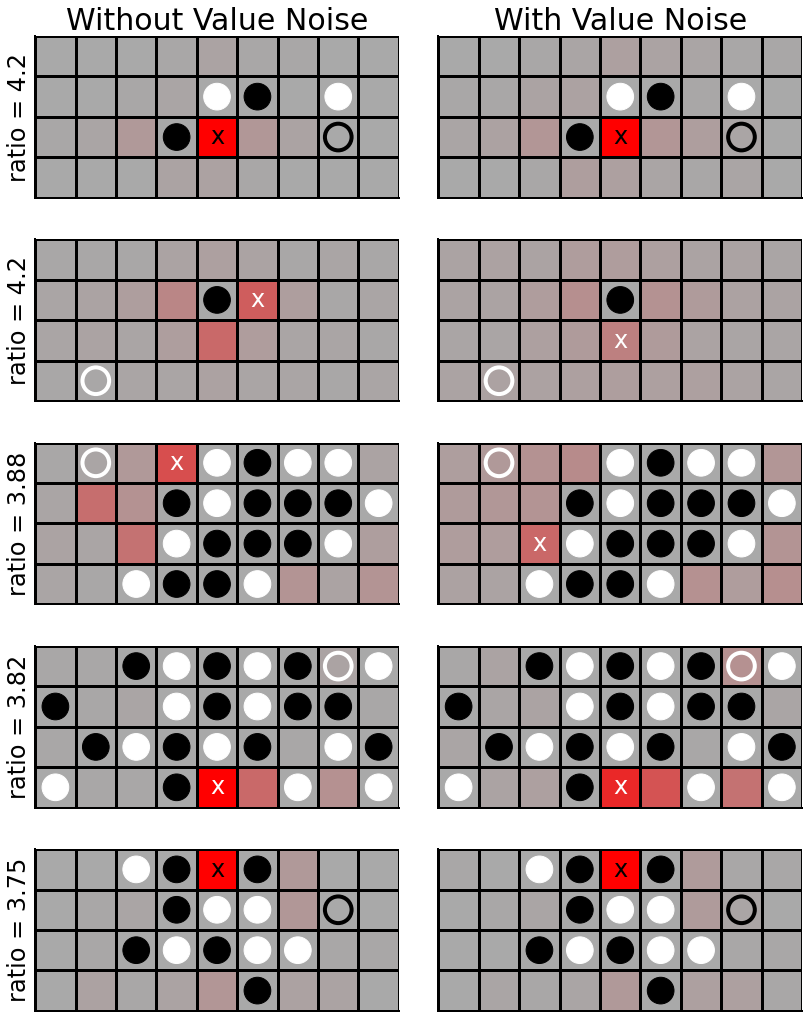

In [24]:
plot_example_boards((np.argsort(x_nonoise)[::-1])[[0,1,2,3,4]],x_nonoise,
                    h_nonoise,'Without Value Noise','With Value Noise','supp_fig_6_rev.pdf',True,prefix='ratio = ',vmax=0.5)

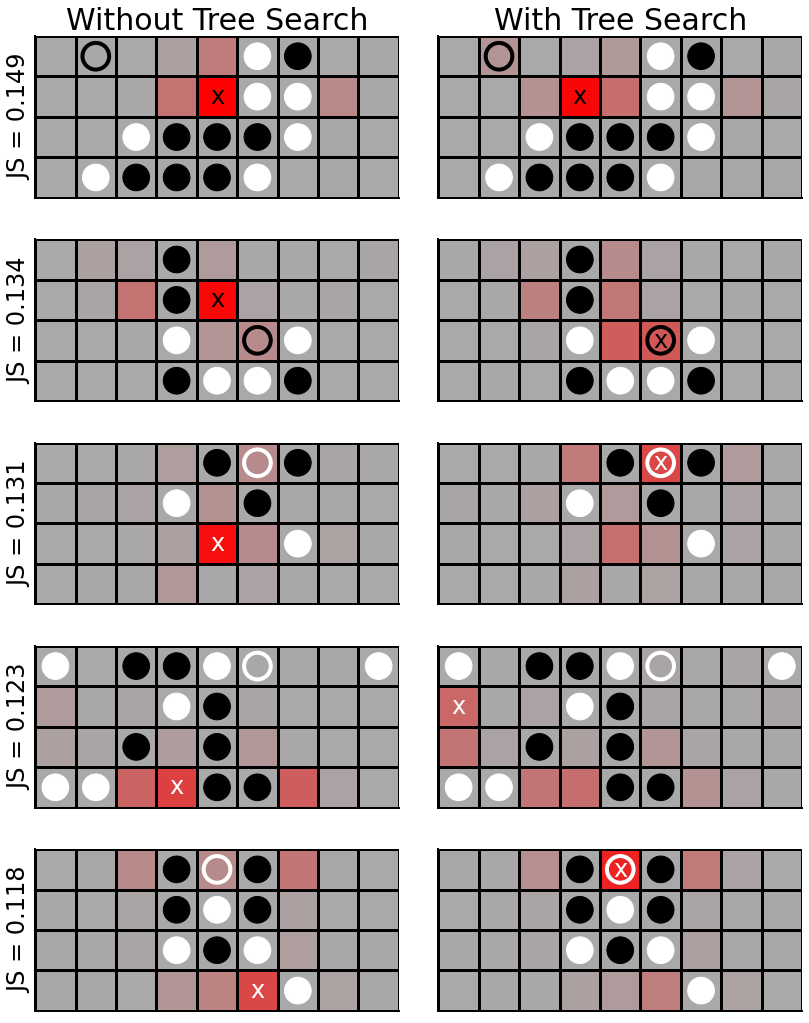

In [25]:
plot_example_boards((np.argsort(x_notree*f)[::-1])[[0,1,2,4,7]],x_notree,
                    h_notree,'Without Tree Search','With Tree Search','supp_fig_3_rev.pdf',True)

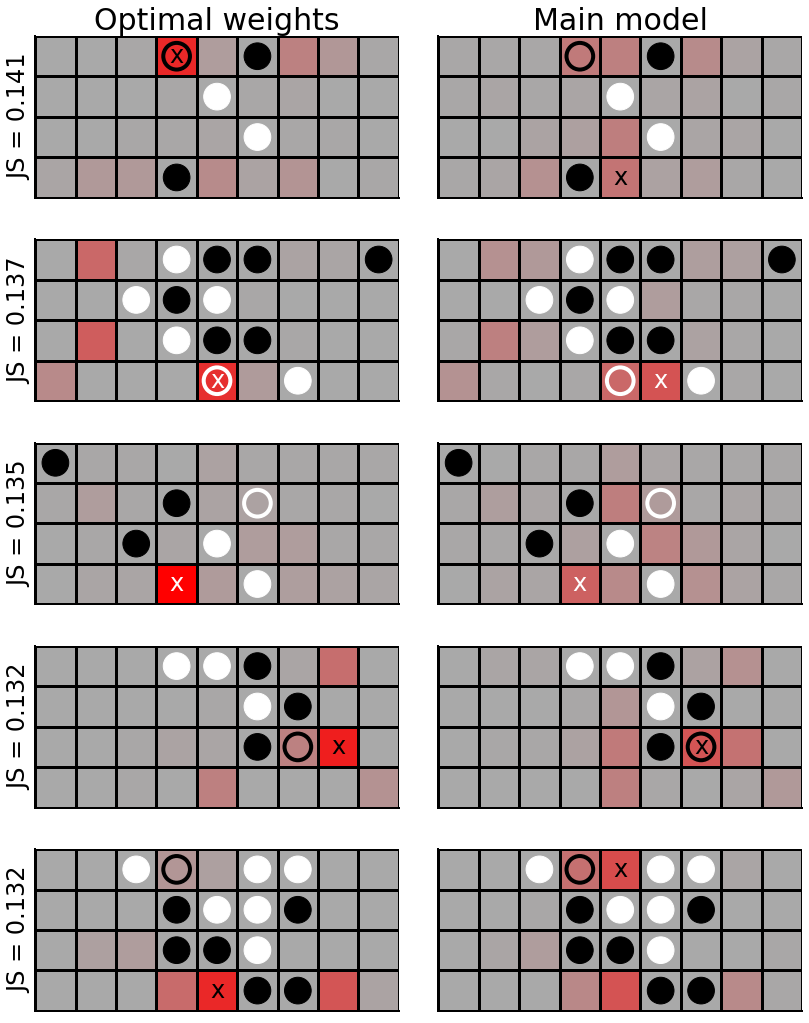

In [26]:
plot_example_boards((np.argsort(x_optweights*f)[::-1])[[0,1,2,4,5]],x_optweights,
                    h_optweights,'Optimal weights','Main model','supp_fig_4_rev.pdf',True)

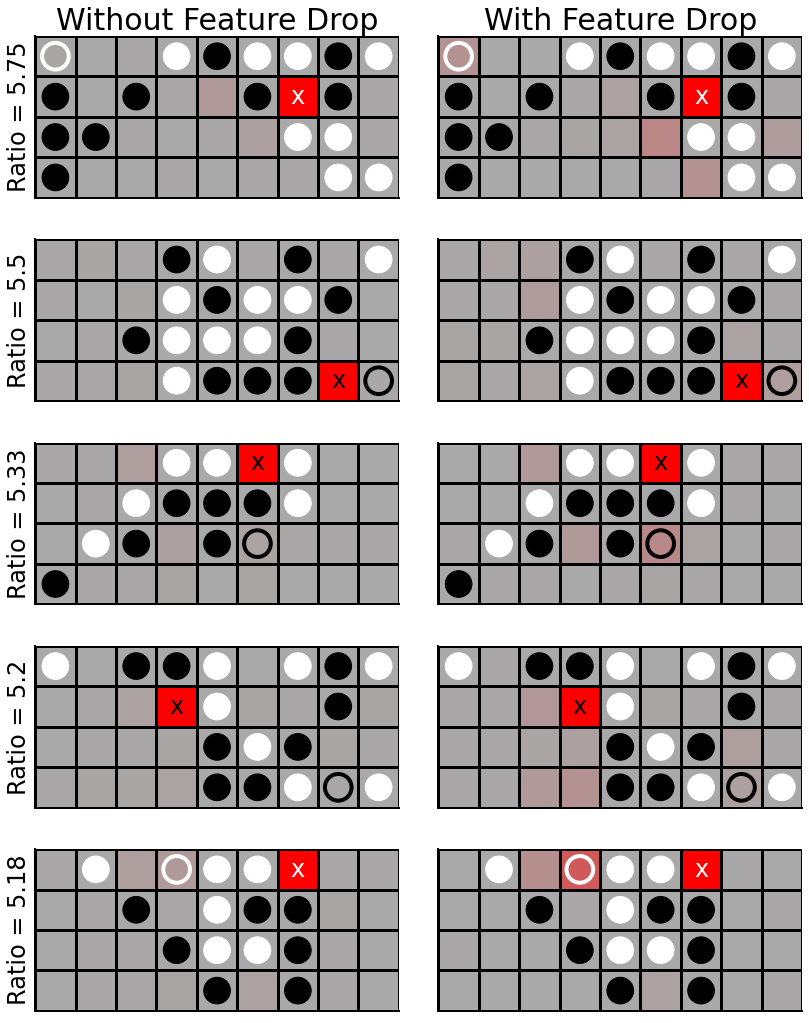

In [27]:
plot_example_boards((np.argsort(x_nodrop*f)[::-1])[[0,1,2,3,4]],x_nodrop,
                    h_nodrop,'Without Feature Drop','With Feature Drop','supp_fig_5_rev.pdf',True,'Ratio = ',vmax=0.25)

In [28]:
(np.argsort(x_nodrop*f)[::-1])[:10]

array([5250, 4114, 3331,  820,  261, 3251,  752, 3061,  748, 1708],
      dtype=int64)

In [29]:
def plot_example_boards_one_col(ind,x,main_title,fig_name,show_human=True,prefix='JS = ',vmax=0.5):

    from matplotlib import colors,patches

    cm = colors.LinearSegmentedColormap.from_list('gray_red_map', [colors.to_rgb('darkgray'), 
                                                                colors.to_rgb('red')], N=100)    
    fig,axes=plt.subplots(len(ind),1,figsize=(6,3*len(ind)))

    for i,j in enumerate(ind):

        ax = axes[i]
        h = np.mean(h_main,axis=2)

        ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5,color='black')
        ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5,color='black')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.axis('off')

        for k in range(36):
            if(black_pieces[j][k]):
                circ = patches.Circle((k%9,k//9),0.33,color="black",fill=True)
                circ = ax.add_patch(circ)
            if(white_pieces[j][k]):
                circ = patches.Circle((k%9,k//9),0.33,color="white",fill=True)
                circ = ax.add_patch(circ)
        k=np.argmax(h[j])
        ax.text(s='x',x=k%9,y=k//9,ha='center',va='center',fontsize=24,
               color=("black" if np.sum(occupied_squares[j])%2==0 else "white"))

        ax.imshow(np.reshape(h[j],[4,9]),
                   cmap=cm,interpolation='nearest',origin='lower',vmin=0,vmax=vmax)
        k=human_move[j]
        if show_human:
            circ = patches.Circle((k%9,k//9),0.33,fill=False,linewidth=4,
                                  color=("black" if np.sum(occupied_squares[j])%2==0 else "white"))
            circ = ax.add_patch(circ)

        ax.set_title(main_title,fontsize=30)
    for i,j in enumerate(ind):
        axes[i].set_ylabel(prefix + '{:.3}'.format(x[j]),fontsize=24)

    
    fig.tight_layout()
    fig.savefig(fig_direc + fig_name)
    plt.show()

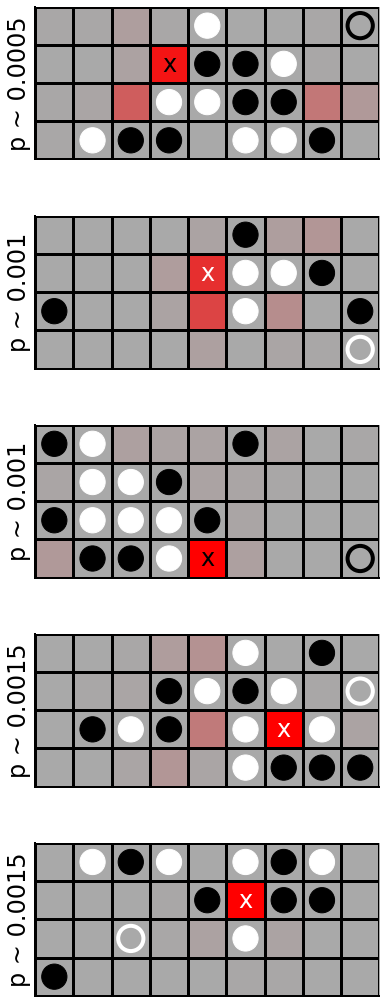

In [30]:
x_lapse = 1-np.mean(h_main[np.arange(5482),human_move],axis=1)
plot_example_boards_one_col((np.argsort(x_lapse*f)[::-1])[[1,2,3,4,7]],1-x_lapse,
                    '','supp_fig_7_rev.pdf',True,'p ~ ',vmax=0.5)

In [8]:
list(zip(models,model_names))

[('final', 'Main'),
 ('final_nonoise', 'No value noise'),
 ('final_nodelta', 'No feature drop'),
 ('final_noprune', 'No pruning'),
 ('final_notree', 'No tree'),
 ('final_noact', 'No active scaling'),
 ('final_no3', 'No 3-in-a-row'),
 ('final_no2conn', 'No connected 2-in-a-row'),
 ('final_nocenter', 'No center'),
 ('final_no4', 'No 4-in-a-row'),
 ('final_no2unc', 'No unconnected 2-in-a-row'),
 ('final_optweights', 'Optimal weights'),
 ('final_mcts_myopic', 'Monte Carlo Tree Search'),
 ('final_drop_tile', 'Tile dropping'),
 ('final_fixed_iters', 'Fixed iterations'),
 ('final_fixed_depth', 'Fixed depth'),
 ('final_fixed_branch', 'Fixed branching'),
 ('final_weight_hvd', 'Orientation-dependent weights'),
 ('final_drop_hvd', 'Orientation-dependent dropping'),
 ('final_triangle', 'Triangle'),
 ('final_drop_type', 'Type-dependent dropping'),
 ('final_opp', 'Opponent scaling')]

In [25]:
with open(direc + 'loglik_all_pickled.txt','rb') as f:
    loglik_all = pickle.load(f)

In [26]:
#loglik_all = [[get_data(direc + 'Loglik/loglik_' + d + '_' + m + '.txt')
#               for m in models] for d in data_sets]
#loglik_all = [np.array(L) for L in loglik_all[:3]] + [np.hstack([np.array(L) for L in loglik_all[3:6]])] + [np.hstack([np.array(L) for L in loglik_all[6:]])]


In [27]:
#with open(direc + 'loglik_all_pickled.txt','wb') as f:
#    pickle.dump(loglik_all,file=f)

In [28]:
def plot_model_comparison(loglik,xrange,figname): 
    
    loglik_main = np.mean(loglik[0,:])
    loglik_diff = np.mean(loglik,axis=1) - loglik_main
    loglik_sem = np.std(loglik - loglik[0,:][None,:],axis=1)/np.sqrt(loglik.shape[1])
    
    fig, ax = plt.subplots(figsize=(12,9))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    xmin = xrange[0]
    ax.set_ylim([0.5,len(model_names)+0.5])
    ax.set_yticks(range(len(model_names),0,-1))
    ax.set_yticklabels(model_names,fontsize=20)
    ax.set_xticks([-2.4,-2.2,-2,-1.8])
    ax.barh(range(len(model_names),0,-1), -loglik_diff, xerr = loglik_sem, height = 0.7, align='center',
         color=model_colors, ecolor='black', left=-loglik_main)
    ax.plot(-loglik_main,len(model_names),'.k')
    ax.axvline(x=-loglik_main, color='black')
    ax.axhline(y=21.5, color='black', linestyle = 'dashed')
    ax.axhline(y=16.5, color='black', linestyle = 'dashed')
    ax.axhline(y=11.5, color='black', linestyle = 'dashed')
    ax.axhline(y=5.5, color='black', linestyle = 'dashed')
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.set_xlim(xrange)
    ax.text(xmin,19, 'Lesions: features', ha ='left', va='center',fontsize=24)
    ax.text(xmin,14, 'Lesions: components', ha ='left', va='center',fontsize=24)
    ax.text(xmin,8.5, 'Modifications', ha ='left', va='center',fontsize=24)
    ax.text(xmin,2.5, 'Extensions', ha ='left', va='center',fontsize=24)
    ax.set_xlabel('Log-likelihood per move')
    fig.subplots_adjust(bottom=0.12,top=0.96,right=0.6,left=0.05)
    #fig.savefig(fig_direc + figname)
    plt.show()


In [42]:
data_sets

['hvh', 'gen', 'eye', 'learn1', 'learn2', 'learn3', 'tai1', 'tai2']

In [32]:
list(zip(model_names,np.round(np.mean(np.hstack(loglik_all),axis=1),6)))

[('Main', 1.954229),
 ('No value noise', 2.056616),
 ('No feature drop', 2.001731),
 ('No pruning', 2.001238),
 ('No tree', 1.98101),
 ('No active scaling', 1.960477),
 ('No 3-in-a-row', 2.211396),
 ('No connected 2-in-a-row', 2.040044),
 ('No center', 2.026131),
 ('No 4-in-a-row', 1.975916),
 ('No unconnected 2-in-a-row', 1.972706),
 ('Optimal weights', 2.012375),
 ('Monte Carlo Tree Search', 2.002949),
 ('Tile dropping', 1.952129),
 ('Fixed iterations', 1.947189),
 ('Fixed depth', 1.944128),
 ('Fixed branching', 1.939918),
 ('Orientation-dependent weights', 1.954692),
 ('Orientation-dependent dropping', 1.954245),
 ('Triangle', 1.952786),
 ('Type-dependent dropping', 1.951774),
 ('Opponent scaling', 1.94804)]

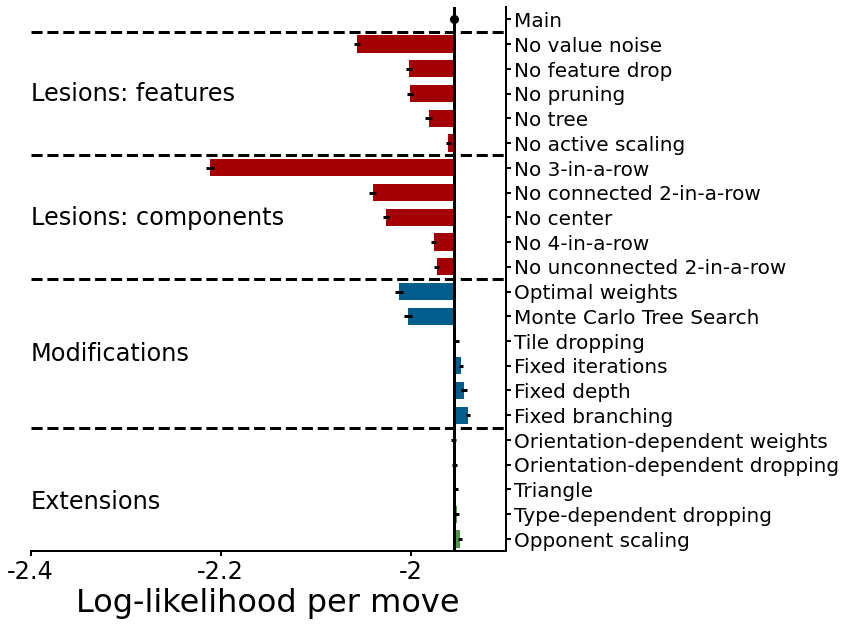

In [33]:
plot_model_comparison(np.hstack(loglik_all),[-2.4,-1.9],'supp_fig_3A.pdf')

In [34]:
def get_alpha_fdr(alpha,allps):
    return allps[np.nonzero(allps > np.arange(1,len(allps)+1)/len(allps)*alpha)[0][0]]

t = [sts.ttest_rel(np.hstack(loglik_all)[0,:],np.hstack(loglik_all)[i,:]) for i in range(np.hstack(loglik_all).shape[0])]

In [35]:
print(get_alpha_fdr(0.05,[tt.pvalue for tt in t]))

0.43679428321841807


In [36]:
t

[Ttest_relResult(statistic=nan, pvalue=nan),
 Ttest_relResult(statistic=-29.986623063287386, pvalue=4.766666326883019e-158),
 Ttest_relResult(statistic=-15.571003122890636, pvalue=4.1445414846168384e-51),
 Ttest_relResult(statistic=-15.175019380240837, pvalue=8.69923835138745e-49),
 Ttest_relResult(statistic=-7.264424139565831, pvalue=5.753443292454445e-13),
 Ttest_relResult(statistic=-2.71525337464452, pvalue=0.006691597782574368),
 Ttest_relResult(statistic=-56.88310811427194, pvalue=0.0),
 Ttest_relResult(statistic=-25.15466469098856, pvalue=1.8896877532472836e-118),
 Ttest_relResult(statistic=-20.696708902164886, pvalue=8.834197594513058e-85),
 Ttest_relResult(statistic=-8.366749597760702, pvalue=1.245389630152811e-16),
 Ttest_relResult(statistic=-7.330666117906075, pvalue=3.571683380498561e-13),
 Ttest_relResult(statistic=-14.625747309416672, pvalue=1.218962470003032e-45),
 Ttest_relResult(statistic=-13.052780184224307, pvalue=3.95873347873122e-37),
 Ttest_relResult(statistic=0.77

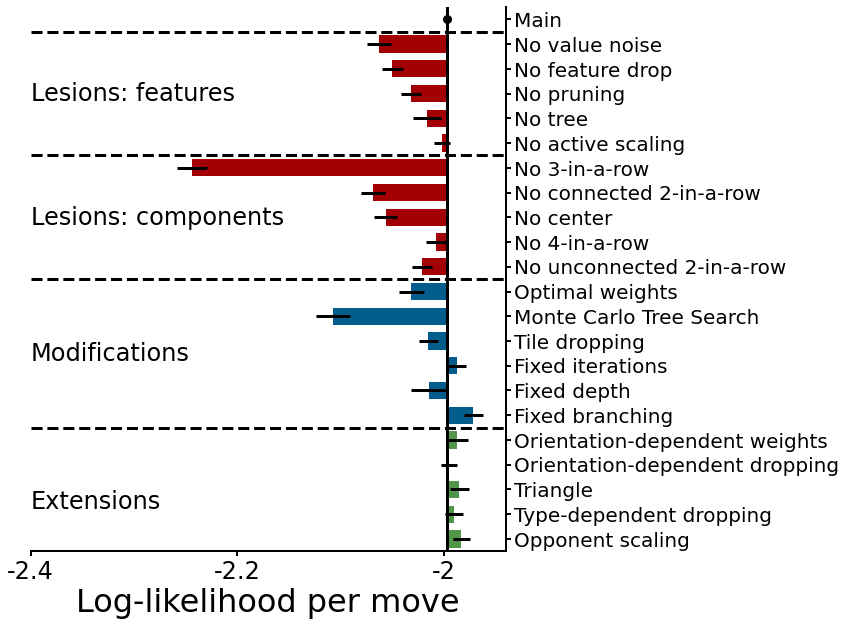

In [37]:
plot_model_comparison(loglik_all[0],[-2.4,-1.94],'supp_fig_3B.pdf')

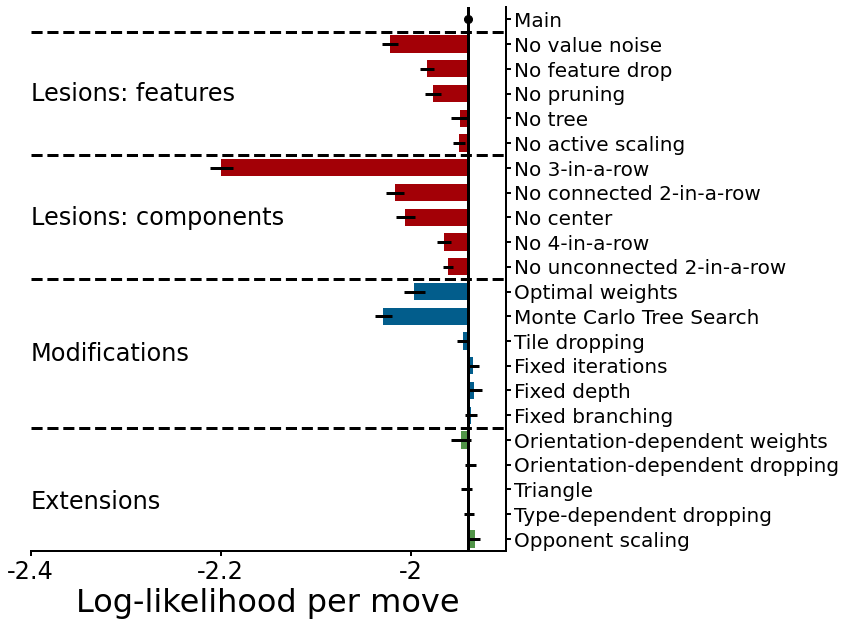

In [38]:
plot_model_comparison(loglik_all[1],[-2.4,-1.9],'supp_fig_3C.pdf')

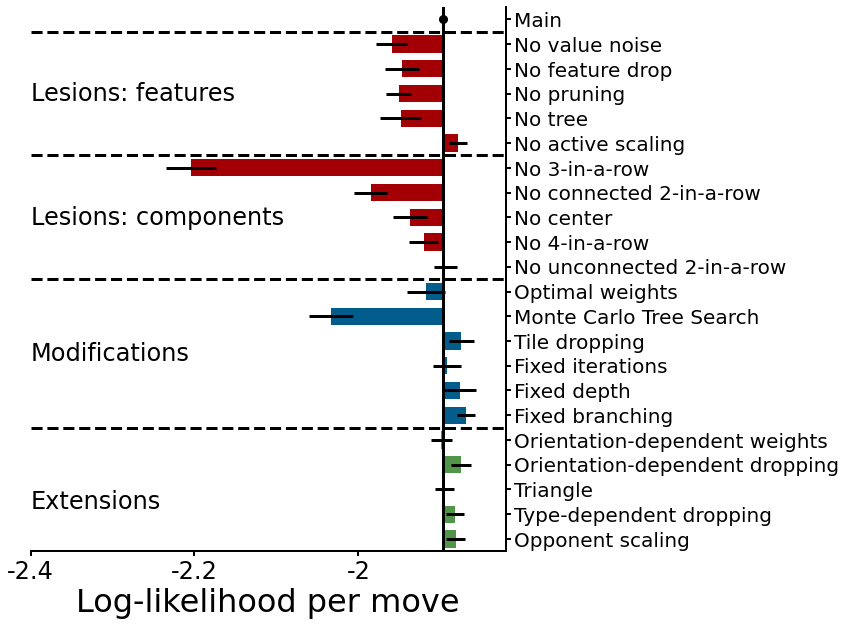

In [39]:
plot_model_comparison(loglik_all[2],[-2.4,-1.82],'supp_fig_3D.pdf')

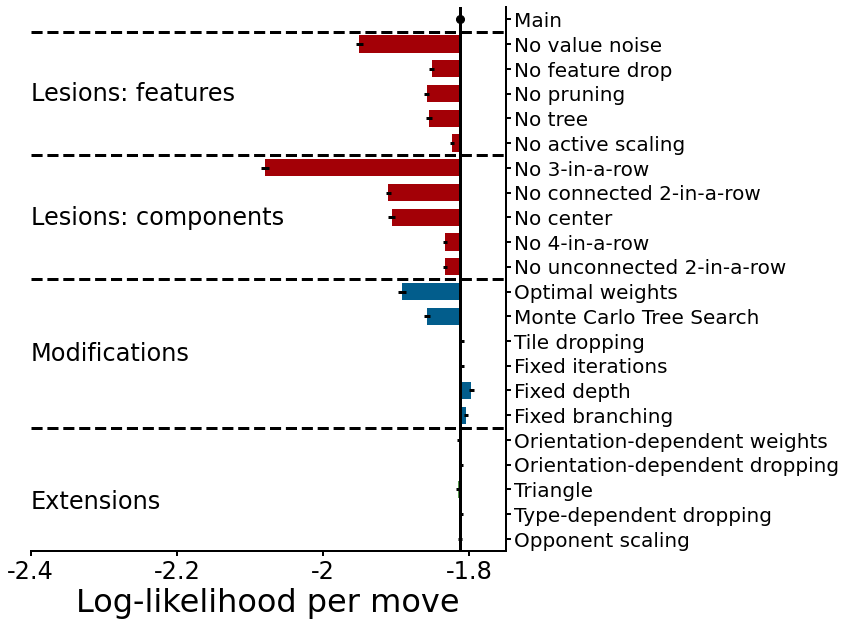

In [40]:
plot_model_comparison(loglik_all[3],[-2.4,-1.75],'supp_fig_3E.pdf')

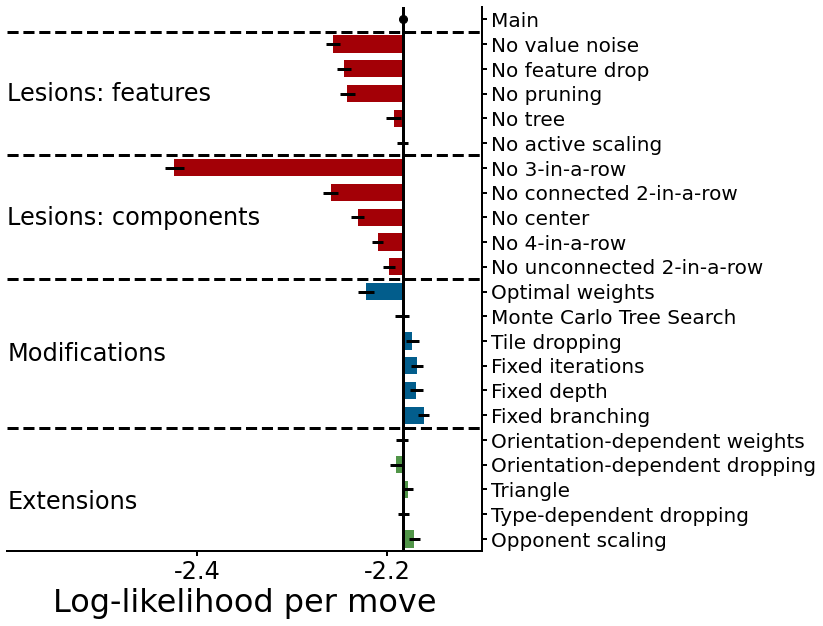

In [41]:
plot_model_comparison(loglik_all[4],[-2.6,-2.1],'supp_fig_3F.pdf')

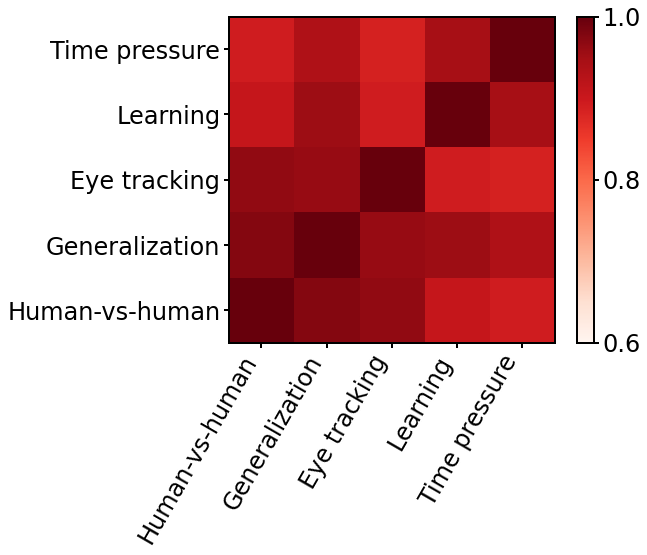

0.9316377464498009 0.010144113121211017


In [45]:
A = np.array([np.mean(L,axis=1) for L in loglik_all])
c = np.corrcoef(A)
data_names= ['Human-vs-human','Generalization','Eye tracking','Learning','Time pressure']

fig, ax = plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

cax = ax.imshow(c,interpolation='nearest',origin='lower',cmap='Reds',vmin=0.6,vmax=1)

ax.set_xticks(range(len(data_names)))
ax.set_yticks(range(len(data_names)))
ax.set_yticklabels(data_names)
ax.set_xticklabels(data_names,rotation=60,ha='right')
ax.set_xlim([-0.5,4.5])
ax.set_ylim([-0.5,4.5])
cbar = fig.colorbar(cax, ticks=[0.6, 0.8, 1])
#fig.savefig(fig_direc + 'supp_figure_model_comp_corr_A.pdf')
plt.show()

print(np.mean(c[np.triu_indices(5,1)]),np.std(c[np.triu_indices(5,1)])/np.sqrt(10))

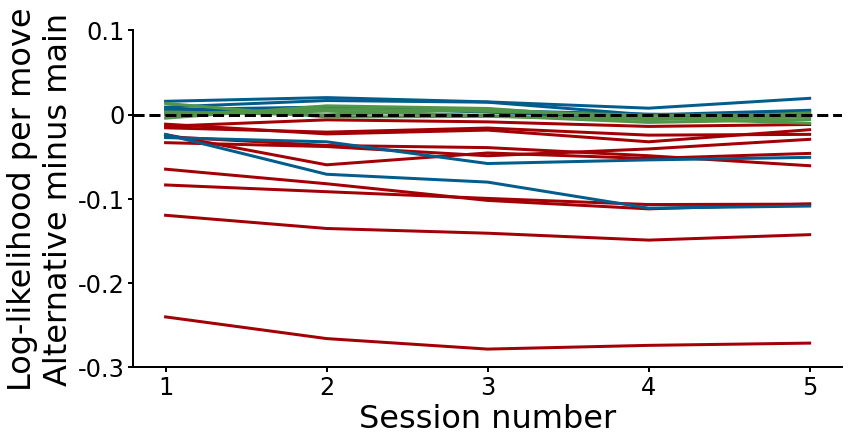

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.set_ylabel('Log-likelihood per move\nAlternative minus main')
ax.set_xlabel('Session number')
ax.set_ylim([-0.3,0.1])
ax.set_xticks(range(6))

loglik_learning = np.mean(np.reshape(loglik_all[3],[22,30,5,5]),axis=(1,3))

for l,c in list(zip(loglik_learning,model_colors))[1:]:
    ax.plot(range(1,6),loglik_learning[0,:]-l,color=c)
ax.axhline(0,color='black',linestyle='dashed')
#plt.plot((loglik_learning - loglik_learning[0,:]).T,color=model_colors)
fig.subplots_adjust(bottom=0.16,right=0.98,left=0.16,top=0.94)
fig.savefig(fig_direc + 'supp_figure_1_rev.pdf')
plt.show()

In [116]:
L_main = [np.hstack([np.loadtxt('C:/Users/svo/Documents/FourinarowData/hvh/main_model/lltest_drop_' 
                                              + str(i) + '_' + str(j) + '.csv') for j in range(1,6)]) for i in range(40)]


In [117]:
L_mean_field = [np.hstack([np.loadtxt('C:/Users/svo/Documents/FourinarowData/hvh/mean_field/lltest' 
                                              + str(i) + '_' + str(j) + '.csv') for j in range(1,6)]) for i in range(40)]


In [118]:
import os
L_drop = [np.hstack([np.loadtxt('C:/Users/svo/Documents/FourinarowData/hvh/drop/lltest_drop_' 
                                              + str(i) + '_' + str(j) + '.csv') if 
         os.path.exists('C:/Users/svo/Documents/FourinarowData/hvh/drop/lltest_drop_' 
                                              + str(i) + '_' + str(j) + '.csv') else [] for j in range(1,6)]) for i in range(40) ]

In [119]:
np.mean(np.hstack(L_drop))

2.009911273257935

In [158]:
params_drop = [np.vstack([np.loadtxt('C:/Users/svo/Documents/FourinarowData/hvh/drop/params_drop_' 
                                              + str(i) + '_' + str(j) + '.csv',delimiter=',') for j in range(1,6)]) for i in range(40) ]

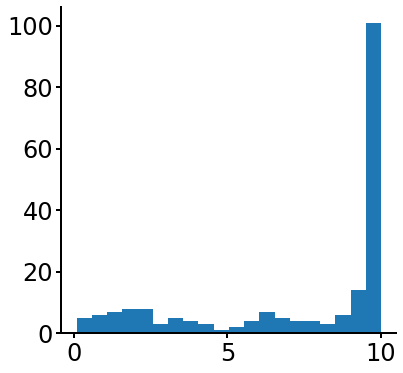

In [169]:
plt.hist(np.vstack(params_drop)[:,0],20)
plt.show()

In [172]:
np.vstack(params_drop).shape

(200, 10)

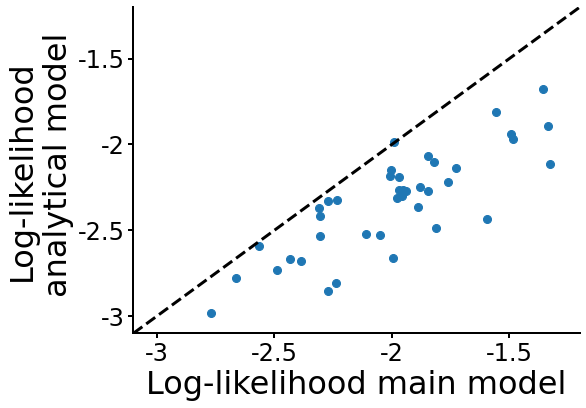

0.3378265263529907 0.03183487383557323
Ttest_relResult(statistic=10.478350523506162, pvalue=6.701595532525702e-13)


In [122]:
fig, ax = plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
xlim = [-3.1,-1.2]

m1 = -loglik_hvh #np.array([-np.mean(L) for L in L_main])
m2 = np.array([-np.mean(L) for L in L_mean_field])
s = np.array([np.std(L)/np.sqrt(len(L)) for L in L_mean_field])
plt.plot(m1,m2,'.')
plt.plot(xlim,xlim,color='black',linestyle='dashed')
plt.xlim(xlim)
plt.ylim(xlim)
plt.xlabel('Log-likelihood main model')
plt.ylabel('Log-likelihood\n analytical model')
plt.show()
print(np.mean(m1-m2),np.std(m1-m2)/np.sqrt(40))
print(sts.ttest_rel(m1,m2))

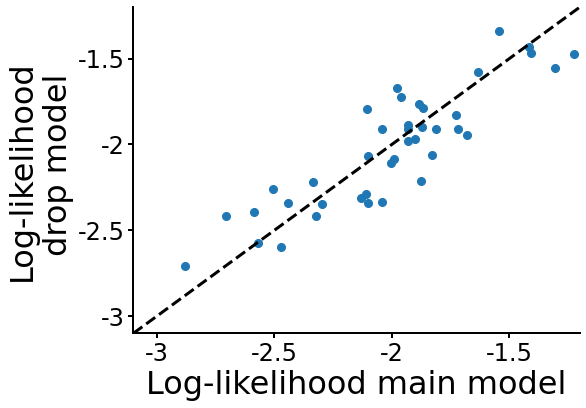

0.015435033414317517 0.0278397407877534
Ttest_relResult(statistic=0.5474502955272592, pvalue=0.5871889081662736)


In [123]:
fig, ax = plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
xlim = [-3.1,-1.2]

m1 = np.array([-np.mean(L) for L in L_main])
m2 = np.array([-np.mean(L) for L in L_drop])
s = np.array([np.std(L)/np.sqrt(len(L)) for L in L_drop])
plt.plot(m1,m2,'.')
plt.plot(xlim,xlim,color='black',linestyle='dashed')
plt.xlim(xlim)
plt.ylim(xlim)
plt.xlabel('Log-likelihood main model')
plt.ylabel('Log-likelihood\n drop model')
plt.show()
print(np.mean(m1-m2),np.std(m1-m2)/np.sqrt(40))
print(sts.ttest_rel(m1,m2))

In [189]:
from fourinarowfunctions import expand_params
np.savetxt(direc + 'params_drop.txt',np.vstack([expand_params(p) for p in np.vstack(params_drop)]),delimiter='\t')

In [202]:
np.corrcoef(np.reshape(np.vstack(params_drop)[:,2],[5,40]))

array([[ 1.00000000e+00, -3.93918554e-04,  2.24839898e-03,
        -2.55495706e-01, -1.89706050e-01],
       [-3.93918554e-04,  1.00000000e+00, -2.35078293e-01,
         6.55488253e-02, -2.52069928e-01],
       [ 2.24839898e-03, -2.35078293e-01,  1.00000000e+00,
         1.48996494e-01,  1.92800003e-01],
       [-2.55495706e-01,  6.55488253e-02,  1.48996494e-01,
         1.00000000e+00,  1.61293087e-01],
       [-1.89706050e-01, -2.52069928e-01,  1.92800003e-01,
         1.61293087e-01,  1.00000000e+00]])

In [101]:
plt.plot(np.vstack(params_drop)[:,1])

NameError: name 'params_drop' is not defined

In [ ]:
para